# Introduction to RNN Architecture

### Recurrent Neural Networks (RNNs) Overview

Idea of Memory: `Hidden State`

The defining feature of an RNN is its internal loop. At each step in processing a sequence, the network considers not only the current input but also information it has retained from previous steps. This retained information is stored in what's called the hidden state.

### Building a Simple RNN in PyTorch

The primary building block for basic RNNs in PyTorch is the `torch.nn.RNN` class.

When creating an instance of `torch.nn.RNN` class ---> it's like creating an RNN layer (or potentially multiple stacked layers) that can process sequences.

Important parameters:

* `batch_first`: A boolean parameter. If `True`, then the input and output tensors are provided as `(batch_size, seq_len, feature_dim)`. If `False` (the default), they are `(seq_len, batch_size, feature_dim)`. Setting this to True is often more intuitive when working with data loaders that yield batches of sequences.

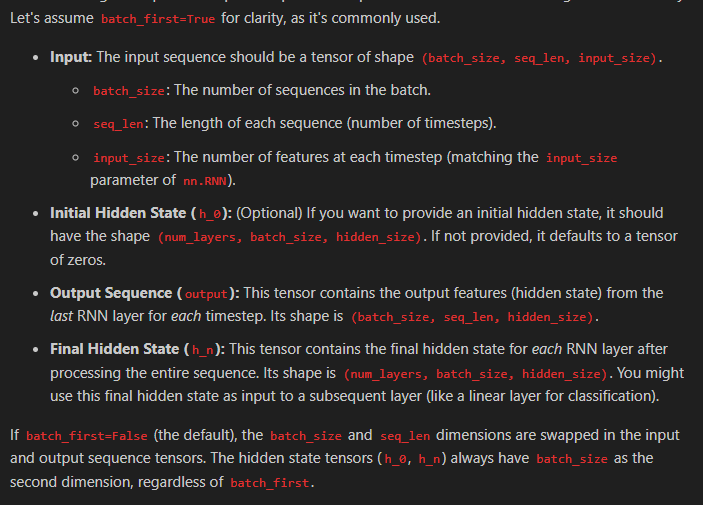

In [1]:
import torch
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_rnn_layers=1):
        """
        Initializes the SimpleRNNModel.

        Args:
            input_dim (int): Dimension of input features per timestep.
            hidden_dim (int): Dimension of the RNN hidden state.
            output_dim (int): Dimension of the final output.
            num_rnn_layers (int): Number of stacked RNN layers. Default is 1.
        """
        # call the __init__ of the parent class (nn.Module)
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_rnn_layers = num_rnn_layers
        
        # defining the RNN layer
        # batch_first=True means input/output tensors shape: (batch, seq, feature)
        self.rnn = nn.RNN(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_rnn_layers,
            batch_first = True, # make sure input shape is (batch, seq_len, input_size)
            nonlinearity = 'tanh' # default activation
        )
        
        # defining output layer (fully connected)
        # it takes the final hidden state of the RNN as input
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        """
        Defines the forward pass of the Model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        # Initialize hidden state with zeros
        # shape: (num_layers, batch_size, hidden_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_rnn_layers, batch_size, self.hidden_dim).to(x.device)
        
        # pass data through RNN Layer
        # rnn_out shape: (batch_size, seq_len, hidden_size)
        # hn shape: (num_layers, batch_size, hidden_size)
        rnn_out, hn = self.rnn(x, h0)
        
        # we only need the hidden state from the last time step of the last layer
        # hn contains the final hidden states for all layers.
        # hn[-1] accesses the final hidden states for all layer.
        # shape of the hn[-1]: (batch_size, hidden_size)
        last_layer_hidden_state = hn[-1]
        
        # pass the last hidden state through the fully connected layer
        # out shape: (batch_size, output_dim)
        out = self.fc(last_layer_hidden_state)
        
        return out

In [2]:
# ----- Example Usage -----

# defining model parameters
# input feature dimension (e.g., embedding size)
INPUT_DIM =  10
HIDDEN_DIM = 20 # Hidden state dimension
OUTPUT_DIM = 5 # Output dimension (e. g., number of classes)
NUM_LAYERS = 1 # number of RNN layers

# create the model
model = SimpleRNNModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)
print("Model Architecture")
print(model)

Model Architecture
SimpleRNNModel(
  (rnn): RNN(10, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=5, bias=True)
)


In [3]:
# dummy input data
BATCH_SIZE = 4
SEQ_LEN = 15
dummy_input = torch.randn(BATCH_SIZE, SEQ_LEN, INPUT_DIM) # shape: (batch, seq, feature)

output = model(dummy_input)

print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([4, 15, 10])
Output shape: torch.Size([4, 5])


In [4]:
# Verify output shape matches (BATCH_SIZE, OUTPUT_DIM)
assert output.shape == (BATCH_SIZE, OUTPUT_DIM)

### Handling Sequential Data Input for RNNs

The Standard RNN Input Shape:
**(Sequence Length, Batch Size, Input Features)**

In [1]:
import torch

# parameters
seq_len = 20 # Longest sequence length
batch_size = 32 # Number of sequences in the batch
input_features = 100 # Dimension of embedding for each word

# dummy input tensor (e.g., filled with random numbers)
# shape: (seq_len, batch_size, input_features)
rnn_input = torch.randn(seq_len, batch_size, input_features)
print(f"Standard RNN Input Shape: {rnn_input.shape}")

Standard RNN Input Shape: torch.Size([20, 32, 100])


If you initialize your RNN layer with `batch_first=True`, it will expect the input tensor shape to be:

**(Batch Size, Sequence Length, Input Features)**

In [3]:
import torch
import torch.nn as nn

# parameters
seq_len = 20
batch_size = 32
input_features = 100
hidden_state = 50 # hidden state for the RNN

# dummy input tensor with batch dimension first
# Shape: (batch_size, seq_len, input_features)
rnn_input_batch_first = torch.randn(batch_size, seq_len, input_features)

# Initialize RNN layer with batch_first=True
rnn_layer = nn.RNN(input_size=input_features, hidden_size=hidden_state, batch_first=True)

# pass the input through the layer (output shape will also have batch first)
output, hidden_state = rnn_layer(rnn_input_batch_first)

print(f"Batch-First RNN Input Shape: {rnn_input_batch_first.shape}")
print(f"Batch-First RNN Output Shape: {output.shape}")

Batch-First RNN Input Shape: torch.Size([32, 20, 100])
Batch-First RNN Output Shape: torch.Size([32, 20, 50])


### Brief Mention of LSTM and GRU

In [5]:
# LSTM

import torch
import torch.nn as nn 

# define an LSTM layer
input_size = 10
hidden_state = 20
num_layers = 2

lstm_layer = nn.LSTM(input_size, hidden_state, num_layers, batch_first=True)

# example input (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 15
dummy_input = torch.randn(batch_size, seq_len, input_size)

# forward pass requires initial hidden and cell states (h_0, c_0)
# if not provided, they default to zeros
# shape: (num_layers * num_directions, batch_size, hidden_size)
h0 = torch.randn(num_layers, batch_size, hidden_state)
c0 = torch.randn(num_layers, batch_size, hidden_state)

output, (hn, cn) = lstm_layer(dummy_input, (h0, c0))
print("LSTM Output shape:", output.shape)
print("LSTM Final Hidden State shape:", hn.shape)
print("LSTM Final Cell State shape:", cn.shape)

LSTM Output shape: torch.Size([5, 20, 20])
LSTM Final Hidden State shape: torch.Size([2, 5, 20])
LSTM Final Cell State shape: torch.Size([2, 5, 20])


In [6]:
# GRUs merge the cell state and hidden state into a single hidden state

# define a GRU layer
gru_layer = nn.GRU(input_size, hidden_state, num_layers, batch_first=True)

h0_gru = torch.randn(num_layers, batch_size, hidden_state)
output_gru, hn_gru = gru_layer(dummy_input, h0_gru)

print("\nGRU Output shape:", output_gru.shape)
print("GRU Final Hidden State shape:", hn_gru.shape)


GRU Output shape: torch.Size([5, 20, 20])
GRU Final Hidden State shape: torch.Size([2, 5, 20])
